In [ ]:
from google.colab import drive 
drive.mount('/saurabh' , force_remount = True)

Mounted at /saurabh


# **CNN+LSTM Hybrid Model for Smartwatch Dataset**

## **Installing Optuna and OptKeras packages which will be used for tuning hyperparameters**

In [ ]:
!pip3 install optuna==0.14.0
!pip3 install optkeras==0.0.7

     |████████████████████████████████| 92kB 6.1MB/s 
     |████████████████████████████████| 81kB 10.3MB/s 
     |████████████████████████████████| 163kB 24.2MB/s 
     |████████████████████████████████| 81kB 11.2MB/s 
     |████████████████████████████████| 51kB 9.9MB/s 
     |████████████████████████████████| 112kB 42.1MB/s 
     |████████████████████████████████| 133kB 27.3MB/s 
     |████████████████████████████████| 81kB 11.5MB/s 
  Created wheel for optuna: filename=optuna-0.14.0-cp36-none-any.whl size=125712 sha256=a91547f8eb5ff257e83768450e717fa1244c38dc98aa3c4d7fcb2fae20a1d2e0
  Stored in directory: /root/.cache/pip/wheels/4f/5f/2b/3c699d0425d8f34f8a81dfebe30f4d2b9f19377f41c57dbae3
  Created wheel for typing: filename=typing-3.7.4.3-cp36-none-any.whl size=26310 sha256=7edd820ca6aeef11d899dbc7a97088f44c729a463f63909297b37c9085055d8a
  Stored in directory: /root/.cache/pip/wheels/2d/04/41/8e1836e79581989c22eebac3f4e70aaac9af07b0908da173be
  Created wheel for PrettyTable: filena

## **Importing the required libraries**

In [ ]:
import os
import statistics
import csv
import itertools
import tensorflow as tf
import keras

import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sn

from tqdm import tqdm_notebook as tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import *
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
import optuna 
print('Optuna', optuna.__version__)

from optkeras.optkeras import OptKeras
import optkeras
print('OptKeras', optkeras.__version__)
from numpy import mean
from numpy import std

# (Optional) Disable messages from Optuna below WARN level.
optuna.logging.set_verbosity(optuna.logging.WARN)

Optuna 0.14.0
OptKeras 0.0.7


In [ ]:
cd /saurabh/My Drive/Datasets/har/wisdm-dataset/

/saurabh/My Drive/Datasets/har/wisdm-dataset


In [ ]:
ls

activity_key.txt            HARWatchGRU_model_000000.h5
arff_files/                 HARWatchGRU_Optuna.csv
arffmagic-master/           inception/
change_raw_act.pl           model1_plot.png
data/                       model_plot2.png
deepconvlstm/               model_plot3.png
HAR_Simple_Keras.csv        model_plot4.png
HAR_Simple_model_000003.h5  model_plot.png
HAR_Simple_Optuna.csv       multichannel.png
HARTrain1_Keras.csv         phone.df
HARTrain1_model_000013.h5   raw/
HARTrain1_Optuna.csv        README.txt
HARTrain_Keras.csv          resnet/
HARTrain_Optuna.csv         watch.df
HARWatchGRU_Keras.csv       WISDM-dataset-description.pdf


## **Loading the watch dataset which was saved in the preprocessing stage**

In [ ]:
watch = pd.read_pickle('watch.df')

In [ ]:
watch.shape

(3731135, 9)

## **Mapping the 18 activities into 3 Groups**

In [ ]:
def activity_mapper(activity):
    if(activity in ['A', 'B', 'C', 'D', 'E', 'M']):
        return 0
    elif(activity in ['P', 'O', 'F', 'Q', 'R','G', 'S']):
        return 1
    else:
        return 2
watch['activity'] = watch['activity'].apply(activity_mapper)

In [ ]:
watch.activity.value_counts()

1    1462798
0    1235394
2    1032943
Name: activity, dtype: int64

In [ ]:
activity_map = {
    0: 'Ambulation Oriented',
    1: 'Hand Oriented General',
    2: 'Hand Oriented Eating'
}

In [ ]:
activities = sorted(activity_map.keys())
activity_encoding = {v: k for k, v in enumerate(activities)}


## **Data Transformation using a sliding windows of 10 seconds = 200 (10 * 20) data points and stride of 50**

In [ ]:
window_size = 200
stride = 50
frames = []
for i in tqdm(range(0, len(watch)-window_size, stride)):
    window = watch.iloc[i:i+window_size]
    if window['activity'].nunique() == 1:
      frames.append(window)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



In [ ]:
#activities = sorted(act_map.keys())
#activity_encoding = {v: k for k, v in enumerate(activities)}

X_list = []
y_list = []

#for each frame replace label with activity
for frame in tqdm(frames):
    X_list.append(frame[['watch_accel_x', 'watch_accel_y', 'watch_accel_z', 'watch_gyro_x', 'watch_gyro_y', 'watch_gyro_z']].values)
    y_list.append(activity_encoding[frame.iloc[0]['activity']])
    #y_list.append(frame.iloc[0][['activity']].values)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



In [ ]:
X = np.array(X_list)
y = np.array(to_categorical(y_list))

In [ ]:
print(X.shape)
print(y.shape)

(73101, 200, 6)
(73101, 3)


In [ ]:
print(X.shape[1:])

(200, 6)


## **Data Splitting  60:20:20**

In [ ]:
#data split: as informed by slides split for 30,000 examples 
#our example is a window and coming from a big expansive amount of data
#5 second split based on papers using 5 sec split. We can play with this 

X_train, X_valtest, y_train, y_valtest = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_valtest, y_valtest, test_size=0.5, random_state=42)

#train
print("X_train: ",X_train.shape)

#dev
print("X_val: ",X_val.shape)

#test
print("X_test: ",X_test.shape)

print("Y_train: ",y_train.shape)
print("Y_val: ",y_val.shape)
print("Y_test: ",y_test.shape)

X_train:  (43860, 200, 6)
X_val:  (14620, 200, 6)
X_test:  (14621, 200, 6)
Y_train:  (43860, 3)
Y_val:  (14620, 3)
Y_test:  (14621, 3)


In [ ]:
# reshape data into time steps of sub-sequences
n_steps, n_length,n_features = 4,50,6
trainX = X_train.reshape((X_train.shape[0], n_steps, n_length, n_features))
valX = X_val.reshape((X_val.shape[0], n_steps, n_length, n_features))
testX = X_test.reshape((X_test.shape[0], n_steps, n_length, n_features))

## **Hyperparameter Optimization Using OptKeras which is based on Optuna - Bayesian Optimization**

In [ ]:
study_name = 'HAR' + 'Train1'

""" Step 1. Instantiate OptKeras class
You can specify arguments for Optuna's create_study method and other arguments 
for OptKeras such as enable_pruning. 
"""

ok = OptKeras(study_name=study_name,
              monitor='val_acc',
              direction='maximize')


""" Step 2. Define objective function for Optuna """

def objective(trial):
    
    """ Step 2.1. Define parameters to try using methods of optuna.trial such as 
    suggest_categorical. In this simple demo, try 2*2*2*2 = 16 parameter sets: 
    2 values specified in list for each of 4 parameters 
    (filters, kernel_size, strides, and activation for convolution).
    """    
    model = Sequential()
    model.add(TimeDistributed(Conv1D(filters=trial.suggest_categorical('filters1', [32,64,96,128]), kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))
    model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    model.add(TimeDistributed(Conv1D(filters=trial.suggest_categorical('filters2', [32,64,96,128]), kernel_size=3, activation='relu')))
    model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    model.add(TimeDistributed(Dropout(rate = trial.suggest_categorical('drop1', [0.05,0.06,0.07,0.08]))))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(64 , return_sequences = True))
    model.add(LSTM(64))
    model.add(Dropout(rate = trial.suggest_categorical('drop2', [0.1,0.2,0.3,0.4])))
    model.add(Dense(y_train.shape[1], activation = 'softmax'))
    
    """ Step 2.2. Specify callbacks(trial) and keras_verbose in fit 
    (or fit_generator) method of Keras model
    """
    model.compile(Adam(),loss=tf.keras.losses.categorical_crossentropy,metrics=['acc'])
    model.fit(trainX,y_train, 
              validation_data=(valX, y_val), shuffle=True,
              batch_size=64, epochs=10,
              callbacks=ok.callbacks(trial),
              verbose=ok.keras_verbose )
    
    
    """ Step 2.3. Return trial_best_value (or latest_value) """
    return ok.trial_best_value

""" Step 3. Run optimize. 
Set n_trials and/or timeout (in sec) for optimization by Optuna
"""
ok.optimize(objective, timeout = 900) 

[2020-12-26 11:30:08.769103] [OptKeras] Ready for optimization. (message printed as verbose is set to 1+)
[2020-12-26 11:30:09.294876]  (None) 
[2020-12-26 11:30:56.631605] Trial#: 0, value: 9.593023e-01| Best trial#: 0, value: 9.593023e-01, params: {'filters1': 64, 'filters2': 96, 'drop1': 0.05, 'drop2': 0.2}
[2020-12-26 11:31:44.167734] Trial#: 1, value: 9.442545e-01| Best trial#: 0, value: 9.593023e-01, params: {'filters1': 64, 'filters2': 96, 'drop1': 0.05, 'drop2': 0.2}
[2020-12-26 11:32:30.999340] Trial#: 2, value: 9.386457e-01| Best trial#: 0, value: 9.593023e-01, params: {'filters1': 64, 'filters2': 96, 'drop1': 0.05, 'drop2': 0.2}
[2020-12-26 11:33:17.841323] Trial#: 3, value: 9.590287e-01| Best trial#: 0, value: 9.593023e-01, params: {'filters1': 64, 'filters2': 96, 'drop1': 0.05, 'drop2': 0.2}
[2020-12-26 11:34:05.191256] Trial#: 4, value: 9.623803e-01| Best trial#: 4, value: 9.623803e-01, params: {'filters1': 96, 'filters2': 128, 'drop1': 0.08, 'drop2': 0.4}
[2020-12-26 11:

In [ ]:
print('Best trial number: ', ok.best_trial.number)
print('Best value:', ok.best_trial.value)
print('Best parameters: \n', ok.best_trial.params)

Best trial number:  14
Best value: 0.9660054445266724
Best parameters: 
 {'filters1': 96, 'filters2': 128, 'drop1': 0.06, 'drop2': 0.1}


In [ ]:
print("Best parameters (retrieved directly from Optuna)", ok.study.best_trial.params)

""" Check the Optuna CSV log file """
pd.options.display.max_rows = 8 # limit rows to display
print('Data Frame read from', ok.optuna_log_file_path, '\n')
display(pd.read_csv(ok.optuna_log_file_path))

""" Check the Keras CSV log file """
pd.options.display.max_rows = 8 # limit rows to display
print('Data Frame read from', ok.keras_log_file_path, '\n')
display(pd.read_csv(ok.keras_log_file_path))

Best parameters (retrieved directly from Optuna) {'filters1': 96, 'filters2': 128, 'drop1': 0.06, 'drop2': 0.1}
Data Frame read from HARTrain1_Optuna.csv 



,number,state,value,datetime_start,datetime_complete,drop1,drop2,filters1,filters2,_Datetime_epoch_begin,_Datetime_epoch_end,_Trial_num,acc,loss,val_acc,val_loss,system_attrs__number
0,0,TrialState.COMPLETE,0.959302,2020-12-26 11:30:08.769704,2020-12-26 11:30:56.119669,0.05,0.2,64,96,2020-12-26 11:30:51.132135,2020-12-26 11:30:55.352998,0,0.968149,0.086918,0.959302,0.107855,0
1,1,TrialState.COMPLETE,0.944254,2020-12-26 11:30:56.120086,2020-12-26 11:31:43.640830,0.08,0.4,32,32,2020-12-26 11:31:38.687086,2020-12-26 11:31:42.876187,1,0.958550,0.114901,0.944254,0.153481,1
2,2,TrialState.COMPLETE,0.938646,2020-12-26 11:31:43.641340,2020-12-26 11:32:30.488420,0.05,0.1,64,32,2020-12-26 11:32:25.576812,2020-12-26 11:32:29.728737,2,0.958003,0.112577,0.938646,0.166001,2
3,3,TrialState.COMPLETE,0.959029,2020-12-26 11:32:30.489137,2020-12-26 11:33:17.295252,0.05,0.2,96,64,2020-12-26 11:33:12.131029,2020-12-26 11:33:16.233334,3,0.964615,0.096222,0.959029,0.108873,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16,16,TrialState.COMPLETE,0.954856,2020-12-26 11:42:44.535356,2020-12-26 11:43:30.109756,0.06,0.1,96,64,2020-12-26 11:43:25.356399,2020-12-26 11:43:29.364274,16,0.965230,0.096380,0.954856,0.130372,16
17,17,TrialState.COMPLETE,0.955882,2020-12-26 11:43:30.112812,2020-12-26 11:44:18.524045,0.06,0.1,96,128,2020-12-26 11:44:13.588493,2020-12-26 11:44:17.754141,17,0.967829,0.089108,0.955882,0.127399,17
18,18,TrialState.COMPLETE,0.953830,2020-12-26 11:44:18.527022,2020-12-26 11:45:07.096343,0.06,0.1,128,128,2020-12-26 11:45:02.069911,2020-12-26 11:45:06.335449,18,0.964866,0.095449,0.953830,0.130209,18
19,19,TrialState.COMPLETE,0.960807,2020-12-26 11:45:07.099405,2020-12-26 11:45:52.765722,0.06,0.3,96,96,2020-12-26 11:45:47.951010,2020-12-26 11:45:51.951803,19,0.968627,0.088463,0.960807,0.117357,19


Data Frame read from HARTrain1_Keras.csv 



,epoch,_Datetime_epoch_begin,_Datetime_epoch_end,_Trial_num,acc,loss,val_acc,val_loss
0,0,2020-12-26 06:36:26.516100,2020-12-26 06:36:39.411224,0,0.828272,0.429519,0.892408,0.281749
1,1,2020-12-26 06:36:39.468646,2020-12-26 06:36:42.753967,0,0.900570,0.265009,0.906224,0.247375
2,2,2020-12-26 06:36:42.802889,2020-12-26 06:36:46.082391,0,0.917693,0.218842,0.912038,0.227891
3,3,2020-12-26 06:36:46.131227,2020-12-26 06:36:49.417641,0,0.930347,0.187226,0.928728,0.187615
...,...,...,...,...,...,...,...,...
426,6,2020-12-26 11:45:35.450817,2020-12-26 11:45:39.515909,19,0.959713,0.112494,0.948564,0.141704
427,7,2020-12-26 11:45:39.573847,2020-12-26 11:45:43.609552,19,0.963520,0.102886,0.948358,0.133747
428,8,2020-12-26 11:45:43.611468,2020-12-26 11:45:47.652691,19,0.964455,0.098092,0.956772,0.121651
429,9,2020-12-26 11:45:47.951010,2020-12-26 11:45:51.951803,19,0.968627,0.088463,0.960807,0.117357


## **CNN 1D + LSTM - Conv1D-MaxPool-Conv1D-MaxPool-DropOut-Flatten-LSTM-DropOut-Dense-SoftMax with best parameters**

In [ ]:
# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=96, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Conv1D(filters=128, kernel_size=3, activation='relu')))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Dropout(0.06)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(64 , return_sequences= True ))
model.add(LSTM(64))
model.add(Dropout(0.1))
model.add(Dense(y_train.shape[1], activation = 'softmax'))


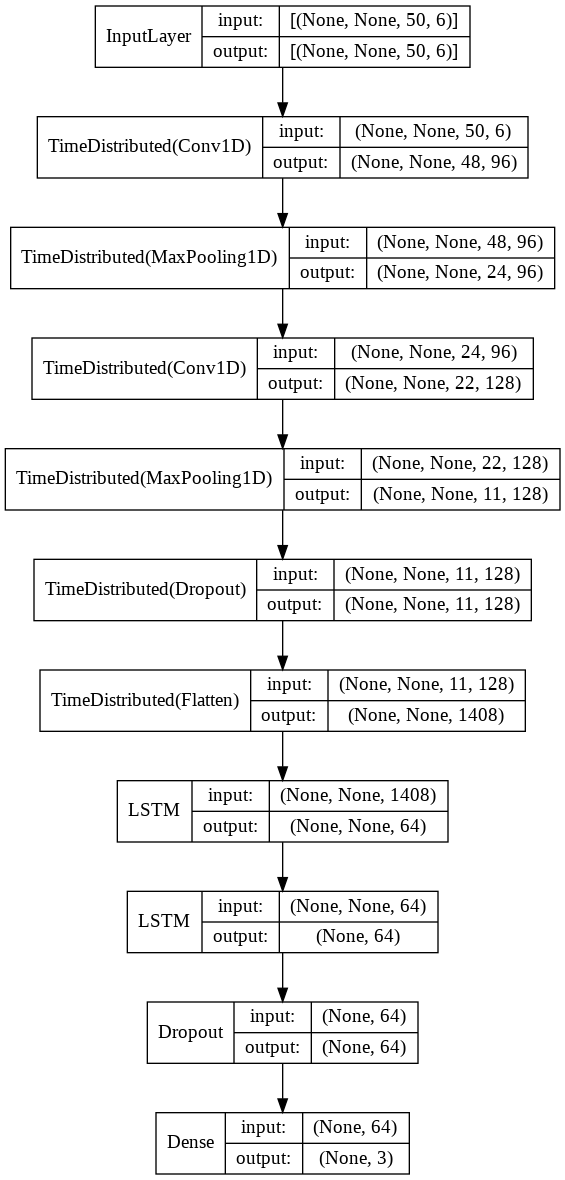

In [ ]:
plot_model(model, to_file='model_plot_cnnlstm.png', show_shapes=True,rankdir = 'TB',expand_nested = False,  show_layer_names=False, show_dtype =False)

In [ ]:
model.compile(Adam(),
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['acc'])

In [ ]:
history = model.fit(trainX,y_train, epochs=25, validation_data=(valX, y_val), verbose=1 , batch_size  = 64 )

Epoch 1/25
686/686 [==============================] - 15s 9ms/step - loss: 0.5484 - acc: 0.7667 - val_loss: 0.2672 - val_acc: 0.9016
Epoch 2/25
686/686 [==============================] - 5s 8ms/step - loss: 0.2651 - acc: 0.8996 - val_loss: 0.2236 - val_acc: 0.9176
Epoch 3/25
686/686 [==============================] - 5s 8ms/step - loss: 0.2155 - acc: 0.9199 - val_loss: 0.1754 - val_acc: 0.9362
Epoch 4/25
686/686 [==============================] - 5s 7ms/step - loss: 0.1768 - acc: 0.9349 - val_loss: 0.1743 - val_acc: 0.9317
Epoch 5/25
686/686 [==============================] - 5s 7ms/step - loss: 0.1535 - acc: 0.9411 - val_loss: 0.1667 - val_acc: 0.9399
Epoch 6/25
686/686 [==============================] - 5s 7ms/step - loss: 0.1321 - acc: 0.9507 - val_loss: 0.1309 - val_acc: 0.9535
Epoch 7/25
686/686 [==============================] - 5s 8ms/step - loss: 0.1145 - acc: 0.9571 - val_loss: 0.1275 - val_acc: 0.9572
Epoch 8/25
686/686 [==============================] - 5s 8ms/step - loss: 0

## **Evaluation - Metrics**

In [ ]:
# Reverse activity encoding encodes index like 3 -> eating sandwich
reverse_activity_encoding = {v: activity_map[k] for k, v in activity_encoding.items()}
lstm_y_val_pred = model.predict(valX)

y_val_argmax = y_val.argmax(axis=1)
y_val_pred_argmax = lstm_y_val_pred.argmax(axis=1)

lstm_actual_val_activities = [reverse_activity_encoding[i] for i in y_val_argmax]
lstm_predicted_val_activities = [reverse_activity_encoding[i] for i in y_val_pred_argmax]

##### Below is Final Test Set results ######
lstm_y_test_pred = model.predict(testX)
lstm_y_test_argmax = y_test.argmax(axis=1)

lstm_y_test_pred_argmax = lstm_y_test_pred.argmax(axis=1)

lstm_actual_test_activities = [reverse_activity_encoding[i] for i in lstm_y_test_argmax]
lstm_predicted_test_activities = [reverse_activity_encoding[i] for i in lstm_y_test_pred_argmax]

In [ ]:
from sklearn.metrics import classification_report 
print("             SmartWatch Results with CNN-LSTM for Validation Set\n\n" + classification_report(lstm_predicted_val_activities,lstm_actual_val_activities , digits = 4))
print("             SmartWatch Results with CNN-LSTM for Test Set\n\n" + classification_report(lstm_predicted_test_activities,lstm_actual_test_activities , digits = 4))

             SmartWatch Results with CNN-LSTM for Validation Set

                       precision    recall  f1-score   support

  Ambulation Oriented     0.9749    0.9611    0.9680      4761
 Hand Oriented Eating     0.9558    0.9748    0.9652      4012
Hand Oriented General     0.9774    0.9752    0.9763      5847

             accuracy                         0.9705     14620
            macro avg     0.9693    0.9704    0.9698     14620
         weighted avg     0.9706    0.9705    0.9705     14620

             SmartWatch Results with CNN-LSTM for Test Set

                       precision    recall  f1-score   support

  Ambulation Oriented     0.9711    0.9590    0.9650      4908
 Hand Oriented Eating     0.9534    0.9725    0.9628      3957
Hand Oriented General     0.9763    0.9732    0.9748      5756

             accuracy                         0.9683     14621
            macro avg     0.9669    0.9682    0.9676     14621
         weighted avg     0.9684    0.9683    0.96

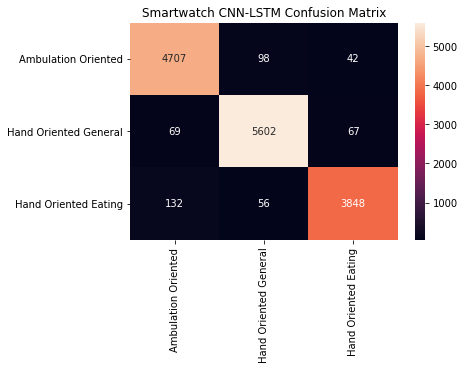

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
lstm_cm = confusion_matrix(lstm_y_test_argmax, lstm_y_test_pred_argmax)
df_cm = pd.DataFrame(lstm_cm, index = [reverse_activity_encoding[i] for i in range(3)], columns = [reverse_activity_encoding[i] for i in range(3)])
#plt.figure(figsize = (12,12))
plt.title('Smartwatch CNN-LSTM Confusion Matrix')
sns.heatmap(df_cm, annot=True, fmt='g')

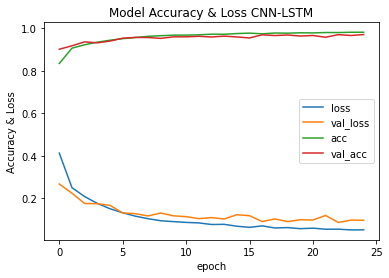

In [ ]:
metrics_history = pd.DataFrame(history.history)
metrics_history[['loss', 'val_loss' , 'acc' , 'val_acc']].plot(title = 'Model Accuracy & Loss CNN-LSTM' , xlabel = 'epoch' , ylabel = 'Accuracy & Loss') #loss = train loss, val_loss = validation Loss


In [ ]:
def evaluate_model(trainX, y_train, testX, y_test):
	# define model
# reshape data into time steps of sub-sequences
  n_steps, n_length,n_features = 4,50,6
  trainX = X_train.reshape((X_train.shape[0], n_steps, n_length, n_features))
  valX = X_val.reshape((X_val.shape[0], n_steps, n_length, n_features))
  testX = X_test.reshape((X_test.shape[0], n_steps, n_length, n_features))
# define model
# define model
  model = Sequential()
  model.add(TimeDistributed(Conv1D(filters=96, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))
  model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
  model.add(TimeDistributed(Conv1D(filters=128, kernel_size=3, activation='relu')))
  model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
  model.add(TimeDistributed(Dropout(0.06)))
  model.add(TimeDistributed(Flatten()))
  model.add(LSTM(64 , return_sequences= True ))
  model.add(LSTM(64))
  model.add(Dropout(0.1))
  model.add(Dense(y_train.shape[1], activation = 'softmax'))
  model.compile(Adam(),
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['acc'])
# fit network
  model.fit(trainX, y_train, epochs=25, batch_size=64, validation_data=(valX, y_val),verbose=0)
# evaluate model
  _, accuracy = model.evaluate(testX, y_test, batch_size=64, verbose=0)
  return accuracy
 
# summarize scores
def summarize_results(scores):
	print(scores)
	m, s = mean(scores), std(scores)
	print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))
 
# run an experiment
def run_experiment(repeats=10):
	# load data
	#trainX, trainy, testX, testy = load_dataset()
	# repeat experiment
	scores = list()
	for r in range(repeats):
		score = evaluate_model(trainX, y_train, testX, y_test)
		score = score * 100.0
		print('>#%d: %.3f' % (r+1, score))
		scores.append(score)
	# summarize results
	summarize_results(scores)

In [ ]:
run_experiment()

>#1: 95.705
>#2: 96.409
>#3: 95.602
>#4: 96.190
>#5: 96.013
>#6: 96.826
>#7: 96.143
>#8: 96.655
>#9: 96.170
>#10: 96.143
[95.70480585098267, 96.40927314758301, 95.60221433639526, 96.19041085243225, 96.01258635520935, 96.82648181915283, 96.14253640174866, 96.65549397468567, 96.16989493370056, 96.14253640174866]
Accuracy: 96.186% (+/-0.359)
